In [220]:
# Configuration step (Please run it before the code!)

import numpy as np
import sys, obspy, os
import matplotlib.pyplot as plt

from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth as gps2DistAzimuth # depends on obspy version; this is for v1.1.0
#from obspy.core.util import gps2DistAzimuth

#from PIL import Image
import requests
from io import BytesIO

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

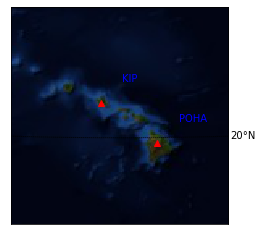

In [221]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# setup Lambert Conformal basemap.
m = Basemap(width=1000000,height=1000000,projection='lcc',
            resolution='c',lat_1=17.,lat_2=23,lat_0=20.918395,lon_0=-157.179)
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
m.bluemarble()
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(0.,81,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])
# plot blue dot on Boulder, colorado and label it as such.
lon, lat = -158.011, 21.42 # Location of KIP
lon1, lat1 = -155.533, 19.757
# convert to map projection coords.
# Note that lon,lat can be scalars, lists or numpy arrays.
xpt,ypt = m(lon,lat)
xpt1,ypt1 = m(lon1,lat1)
# convert back to lat/lon
lonpt, latpt = m(xpt,ypt,inverse=True)
lonpt1, latpt1 = m(xpt1,ypt1,inverse=True)
m.plot(xpt,ypt,'r^')  # plot a blue traingle there
m.plot(xpt1,ypt1,'r^')
# put some text next to the dot, offset a little bit
# (the offset is in map projection coordinates)
plt.text(xpt+100000,ypt+100000,'KIP',color='b')
plt.text(xpt1+100000,ypt1+100000,'POHA',color='b')
plt.savefig(fname='Hawaii_station_1',format='png',dpi=500)
plt.show()

In [222]:
stn = obspy.read('F:\\7th sem\\Strong Motion Data\\Self research projects\\Ambient seismic noise tomography\\data\\kipfdsnws-dataselect_2020-09-21t10_29_05z.mseed')
    # get noise data for the station PHL and add it to the previous stream
stn += obspy.read('F:\\7th sem\\Strong Motion Data\\Self research projects\\Ambient seismic noise tomography\\data\\pohalhzfdsnws-dataselect_2020-09-21t10_24_09z.mseed')
    # if you have data stored locally, comment the stn = and stn += lines above

In [223]:
stn

3 Trace(s) in Stream:
IU.KIP.00.LHZ  | 2015-01-01T00:00:00.069500Z - 2015-03-31T22:57:13.069500Z | 1.0 Hz, 7772234 samples
IU.KIP.00.LHZ  | 2015-03-31T22:57:47.069542Z - 2015-04-01T11:59:59.069542Z | 1.0 Hz, 46933 samples
IU.POHA.00.LHZ | 2015-01-01T00:00:00.069500Z - 2015-02-28T23:59:59.069500Z | 1.0 Hz, 5097600 samples

In [224]:

stn[0]=stn[0].trim(starttime=UTCDateTime('2015-01-01T00:00:00.069500Z'),endtime=UTCDateTime('2015-02-28T23:59:59.069500Z'))

In [225]:
stn

3 Trace(s) in Stream:
IU.KIP.00.LHZ  | 2015-01-01T00:00:00.069500Z - 2015-02-28T23:59:59.069500Z | 1.0 Hz, 5097600 samples
IU.KIP.00.LHZ  | 2015-03-31T22:57:47.069542Z - 2015-04-01T11:59:59.069542Z | 1.0 Hz, 46933 samples
IU.POHA.00.LHZ | 2015-01-01T00:00:00.069500Z - 2015-02-28T23:59:59.069500Z | 1.0 Hz, 5097600 samples

In [226]:
stp=[stn[0],stn[2]]

In [227]:
stp

[IU.KIP.00.LHZ | 2015-01-01T00:00:00.069500Z - 2015-02-28T23:59:59.069500Z | 1.0 Hz, 5097600 samples,
 IU.POHA.00.LHZ | 2015-01-01T00:00:00.069500Z - 2015-02-28T23:59:59.069500Z | 1.0 Hz, 5097600 samples]

In [228]:
stp= obspy.Stream(stp)

In [229]:
stp

2 Trace(s) in Stream:
IU.KIP.00.LHZ  | 2015-01-01T00:00:00.069500Z - 2015-02-28T23:59:59.069500Z | 1.0 Hz, 5097600 samples
IU.POHA.00.LHZ | 2015-01-01T00:00:00.069500Z - 2015-02-28T23:59:59.069500Z | 1.0 Hz, 5097600 samples

In [230]:
stp.detrend('linear')                                            # remove trends using detrend
stp.taper(max_percentage=0.05, type='cosine')                    # taper the edges
stp.filter('bandpass', freqmin=0.1, freqmax=0.2, zerophase=True) 

2 Trace(s) in Stream:
IU.KIP.00.LHZ  | 2015-01-01T00:00:00.069500Z - 2015-02-28T23:59:59.069500Z | 1.0 Hz, 5097600 samples
IU.POHA.00.LHZ | 2015-01-01T00:00:00.069500Z - 2015-02-28T23:59:59.069500Z | 1.0 Hz, 5097600 samples

In [231]:
# Functions
# collection of functions used in noise correlation processing

def normalize(tr, clip_factor=6, clip_weight=10, norm_win= 4, norm_method="1bit"): 
# we would like to ensure that we have as isotropic source generated field as possible, sometimes due to 
# earthquakes, the signal generated is no longer isotropic, therefore we would like to remove the 
# effect of all the earthquakes and other particular undirectional sources on our signal before correlating
# that's why we need normalization. There are 5 methods given in Bensen et al. 2007,which are shown here
    if norm_method == 'clipping':
        lim = clip_factor * np.std(tr.data)
        tr.data[tr.data > lim] = lim
        tr.data[tr.data < -lim] = -lim
# std will calculate the standard deviation along any axis, the plan is to clip all the amplitudes beyond
#certain limits which is normally caused by earthquake level source. 
#standard deviation is a quantitative measure of hwo much the values differs from the mean of the group
# remember the formula of standard deviation = (xi-mean/N)^(0.5), we can change the clip factors according to our need and even
# plot the graph of snr with clip_factor
    elif norm_method == "clipping_iter":
        lim = clip_factor * np.std(np.abs(tr.data))
# as long as still values left above the waterlevel, clip_weight
#as long as the magnitude is still above certain value divide it by the clip weight
        while tr.data[np.abs(tr.data) > lim] != []:
            tr.data[tr.data > lim] /= clip_weight
            tr.data[tr.data < -lim] /= clip_weight

    elif norm_method == 'ramn':
#running absolute mean normlisaton, 
        lwin = int(tr.stats.sampling_rate * norm_win)
        st = int(0)                                             # starting point
        N = lwin                                             # ending point
        while N < tr.stats.npts:
            win = np.array(tr.data[int(st):int(N)])
            win = np.abs(win)
            w = np.mean(win) / (2. * lwin + 1)
            
            # weight center of window
            tr.data[int(st) +int(lwin / 2)] /= w

            # shift window
            st += 1
            N += 1

        # taper edges
        taper = get_window(tr.stats.npts)
        tr.data *= taper
# 1 bit normalisation method
    elif norm_method == "1bit":
        tr.data = np.sign(tr.data)
        tr.data = np.float32(tr.data)
    elif norm_method =="trigger":  # new normalisation method
        sta_window = 2         # window for short term average, currently 2 works out best
        lta_window = 30        # window for long term average, 30 proves to give out best result in this case
        pet_window = 45        # post event time length for which we will apply the correction
        threshold  = 40        # threshold values for sta/lta, i have checked from 5,10,20,30,40,50 and 40 proves to be best in this case
        for i in range(31,len(tr)-45):
            sta = (tr.data[i]+tr.data[i-1])/2
            lta = sum(tr[i-30:i])/len(tr[i-30:i])
            if np.abs(sta/lta) >= threshold:
                tr.data[i:i+45] = np.ones(len(tr.data[i:i+45]))

    return tr


def get_window(N, alpha=0.2):  #how to create a window

    window = np.ones(N)           # making an array of ones  
    x = np.linspace(-1., 1., N)   # make an array 
    ind1 = (abs(x) > 1 - alpha) * (x < 0)
    ind2 = (abs(x) > 1 - alpha) * (x > 0)
    window[ind1] = 0.5 * (1 - np.cos(np.pi * (x[ind1] + 1) / alpha)) # see the formula for hann window
    window[ind2] = 0.5 * (1 - np.cos(np.pi * (x[ind2] - 1) / alpha))
    return window
# hann window is a cosine shaped window, the time period of cosine(ax) will be given by 2*pi/a, multiplying
#something with the input stretches or compresses our original function.
#here x is given by an array -- [-1 -1+2/N -1+4/N -1+6/N .. -1+n/N  .. 1] = total number of elements= 2N
# ind1 represents the multiplication of two boolean arrays 1*0 = 0 it represents the intersection of 
# x<0 and abs(x) > 1-alpha that would be the last and first 20% of our whole x
# now we have selected our indexes, window 1 = (1/2)(1 - cos(pi(-1+n/2N+1)/alpha))
# so window 1 = (1/2)(1-cos(pi(n/2Nalpha))) now our variable is n which will vary from n = 0 to 2N
#now consider this  lets call alpha =a, therefore time period will be 2pi/(pi/2Na) = 4Na
# for for N = 100 and a = 0.2 T= 80s, so at 40 seconds it will be one half cycle, at 20 seconds it will be 1/4
# of cycle, and that's what we wanted to do, we wanted our first and last 20% to smoothly decrease to 0
# to avoid gibb's phenomenon. If we take a = 0.1 , our T = 40s, it means we will have one half cycle at 20, which is not desirable
# if a = 0.5 it means T=200s, so only 1/10 of cycle at 20 s that's not desirable either, checkout the cases
# by practicing in the columns below 
def whiten(tr, freqmin, freqmax): # whitening means making the amplitude of all frequencies in the amplitude spectrum 
    #equal 
    
    nsamp = tr.stats.sampling_rate #nsamp = 1Hz
    
    n = len(tr.data) # n = 86401
    if n == 1:
        return tr
    else: 
        frange = float(freqmax) - float(freqmin)  # frange = 0.1
        nsmo = int(np.fix(min(0.01, 0.5 * (frange)) * float(n) / nsamp)) #nsmo = 864
        #fix rounds the elements of an array to the nearest integer towards 0.
        f = np.arange(n) * nsamp / (n - 1.) 
        # arrange(start,stop,step) by defaul start = 0,step =1, produces an array of integers from 0 to n
        # produces an array of an integer with [start,stop)
        # so f = [0 1/86400 2/86400 ..  1] so total 86401 elements
        
        JJ = ((f > float(freqmin)) & (f<float(freqmax))).nonzero()[0]
        # .nonzero() function is used to compute the indices of non zero elements in an array.   
        # JJ is a tuple whose first element is an array[8641 8642... 17289], so index[0] will refers to array[8641, 8642 ..17289] etc.
        # signal FFT
        FFTs = np.fft.fft(tr.data)
        FFTsW = np.zeros(n) + 1j * np.zeros(n)
        # fft calculates the 1 D discrete fourier transform, X(k) = summation of n from [1,N], x(n)e^(-j2(pi)nk/N), see the formula for its inverse on the internet.
        # n/N this expression represents time in time series, so corresponding frequency will vary from 1 to N
        # it will output complex values, hence FFTsW is initialized.
        # Apodization to the left with cos^2 (to smooth the discontinuities)
        smo1 = (np.cos(np.linspace(np.pi / 2, np.pi, nsmo+1))**2)
        # smo1 = cos(pi/2 pi 865)^2 in pi/2 to pi, cos varies from 0 to -1, it will divide the interval[pi/2,pi] to 865 equal points
        FFTsW[JJ[0]:JJ[0]+nsmo+1] = smo1 * np.exp(1j * np.angle(FFTs[JJ[0]:JJ[0]+nsmo+1]))
        # jj[0] = 8641, jj[0]+nsmo+1 = 9506, np.angle= returns the angle of complex argument in radians, so our net equation is like
        # cos^(2)*e^(jtheta)
        # boxcar
        FFTsW[JJ[0]+nsmo+1:JJ[-1]-nsmo] = np.ones(len(JJ) - 2 * (nsmo+1))\
        * np.exp(1j * np.angle(FFTs[JJ[0]+nsmo+1:JJ[-1]-nsmo]))
        # making the boxcar function by making the magnitude equal to one for the intermediate frequency.
        # Apodization to the right with cos^2 (to smooth the discontinuities)
        smo2 = (np.cos(np.linspace(0., np.pi/2., int(nsmo+1.))**2.))
        # now here cos varies from 1 to 0, so our goal is to apode the last portion of amplitude spectrum, so to smoothly goes to 
        # o outside our require frequency band 
        espo = np.exp(1j * np.angle(FFTs[JJ[-1]-nsmo:JJ[-1]+1]))
        FFTsW[JJ[-1]-nsmo:JJ[-1]+1] = smo2 * espo
        # so we have taken the amplitude spectrum of our trace data, and we make the amplitudes uniform in our required frequency band 
        # and we apoded the front and end parts of our amplitude spectrum by multiplyiing by cos^2, outside of our frequency band of interest
        # note that  only amplitude spectrum was made uniform, whereas phase spectrum remains unchanged

        whitedata = 2. * np.fft.ifft(FFTsW).real
        # taking the 1D inverse fourier transform of the data
        # http://faculty.salina.k-state.edu/tim/mVision/freq-domain/DFT.html -check the formula here. .real will only take the magnitude of the final.
        tr.data = np.require(whitedata, dtype="float32")
        # .require will return an array which satisfy the given elements
        return tr
        # so our trace is now whitened for further processing. now it becomes perfectly random

def correlateNoise(st, stations, corrwin):

    print ('correlating stations', (stations[0], stations[1]))

    # initialize sliding timewindow (length = corrwin) for correlation
    # start 1 corrwin after the start to account for different stream lengths
    timewin = st.select(station=stations[1])[0].stats.starttime + corrwin
    # st.select (station = "MLAC") will return the stream object containing all the traces associated with station= MLAC
    # so we selected the first element of such stream and made a time window with a lenght of corrwin.
    # loop over timewindows 
    # stop 2 corrwin before the end to account for different stream lengths
    while timewin < st.select(station=stations[0])[-1].stats.endtime - 2*corrwin:
        # select the last trace in such stream, and stop the timeloop before the twice of window length to account for varying length
        sig1 = st.select(station=stations[0]).slice(timewin, timewin+corrwin)
        # slice will slice the stream and outputs new stream containing only the sliced portion.
        sig1.merge(method=0, fill_value=0)
        # merge will fill the gaps in the trace in the stream by the mentioned fill value, maybe that's what we call padding
        sig2 = st.select(station=stations[1]).slice(timewin, timewin+corrwin)
        sig2.merge(method=0, fill_value=0)
        # now we have 2 signals for the correlation
        xcorr = np.correlate(sig1[0].data, sig2[0].data, 'same')
        # np.correlate(a,b, mode = same), checkout the definition of correlation on np.correlate, same mode will output the elements
        # equal to the number of elements max(a,b), so basically in cross correlation we take 2 functions, and we keep 1 fixed and shift the other one
        # by distances also known as lags, calculate and sum the multiplication of the corresponding elements at each function. 
        # when the 2 functions are same, it is called autocorrelation, ofcourse, it will be maximum at 0 lag
    
        try: 
            # build array with all correlations
            corr = np.vstack((corr, xcorr))
            # vstack stacks the arrays vertically (row wise) so example corr = [[1,2,3],
            #[1,2,3]
            #[2,3,4]]
            # so it will stack the correlated arrays verticaly in each loop
            # check the np.vstack for more examples
        except: 
            # way to handle exceptions, Normally the condition in Try will execute,if there is any exception condition in Except column
            # will execute
            # if corr doesn't exist yet
            corr = xcorr
            
        # shift timewindow by one correlation window length
        timewin += corrwin

        # stack the correlations; normalize
        stack = np.sum(corr, 0) # sum of all elements of an array along specified axis, so stack basically means the summing up?
        # stacking the correlations so dor example sum(corr) = ([4,7,10]) all the elements will be summed verticaly
        # 0 for vertical axis, 1 for horizontal axis
        # the number of elements in the stack will be equal to time window.
        stack = stack / float((np.abs(stack).max()))    
        # normalizing means dividing the whole by maximum number 
    print ("...done")

    return corr, stack


def plotStack(st, stack, maxlag, figurename='1bit'):

    # define the time vector for the correlation (length of corr = corrwin + 1)
    limit = (len(stack) / 2.) * st[0].stats.delta
    timevec = np.arange(-limit, limit, st[0].stats.delta) # there will be only 7200 elements in timevec
    # remember arrange gives [start,stop)
    # will just plot the values of stacked correlation
    plt.plot(timevec, stack, 'k')
    stations = list(set([_i.stats.station for _i in st]))
    plt.title("Stacked correlation between %s and %s" % (stations[0], stations[1]))
    plt.xlim(-maxlag, maxlag)
    plt.xlabel('time [s]')

    if figurename is not None:
        plt.savefig(figurename, format="png")
    else:
        plt.show()
        
        
def plotXcorrEvent(st, stn, stack, maxlag, acausal=False, figurename=None):
    # plotting for the event part
    # basically we are plotting the waveform produced by the event v/s the velocity
    # and we are plotting the stacked cross correlation v/s the velocity
    # turns out that their shapes are very similar
    # also we can see the low frequence (greater time periods) have more velocity
    # so it is proved that the cross correlation of random noise between 
    eventtime = UTCDateTime(2018,5,4,22,32,55,0)                 # event near MLAC

    # station locations
    latP, lonP = 21.42, -158.01                                  # station KIP
    latM, lonM = 19.75, -155.53                                  # station POHA
    latE, lonE = 19.313, -154.99                                 # event 2018
    
    # calculate distance between stations
    dist = gps2DistAzimuth(latP, lonP, latM, lonM)[0]            # between PHL and MLAC
    distE = gps2DistAzimuth(latP, lonP, latE, lonE)[0]           # between event and PHL
                                                                 # outputs distance in metres
    # CROSSCORRELATION
    # reverse stack to plot acausal part (= negative times of correlation)
    if acausal:
        stack = stack[::-1]   # if it is acausal, then it will reverse the stack
    # causal system is a system where the output depends only on the past and present values and not the future values.
    
    # find center of stack
    c = int(np.ceil(len(stack)/2.) + 1)   #check correction : it should be floor function and not ceil
    # ceil(x) = the smallest integer not less than x
    #cut stack to maxlag
    stack = stack[c - maxlag * int(np.ceil(stn[0].stats.sampling_rate)) : c + maxlag * int(np.ceil(stn[0].stats.sampling_rate))]
    # find new center of stack
    c2 = int(np.ceil(len(stack)/2.) + 1)   # check this for correction
    # define time vector for cross correlation
    limit = (len(stack) / 2.) * stn[0].stats.delta # in this case delta = 1s and len(stack) = 7200
    timevec = np.arange(-limit, limit, stn[0].stats.delta) # so timevec will go from -3600 to 3600 with the step sie of +1
    # define timevector: dist / t
    timevecDist = dist / timevec
    
    # EVENT
    ste = st.copy()
    st_PHL_e = ste.select(station='KIP')
    
    # cut down event trace to 'maxlag' seconds
    dt = len(stack[c2:])/stn[0].stats.sampling_rate                  #xcorrlength
    st_PHL_e[0].trim(eventtime, eventtime + dt)
    
    # create time vector for event signal
    # extreme values:
    limit = st_PHL_e[0].stats.npts * st_PHL_e[0].stats.delta
    timevecSig = np.arange(0, limit, st_PHL_e[0].stats.delta)

    # PLOTTING
    fig = plt.figure(figsize=(12.0, 6.0))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    # plot noise correlation
    ax1.plot(timevecDist[c2:], stack[c2:], 'k')
    ax1.set_title('Noise correlation between KIP and POHA')

    # plot event near MLAC measured at PHL
    ax2.plot(distE/timevecSig, st_PHL_e[0].data / np.max(np.abs(st_PHL_e[0].data)), 'r')
    ax2.set_title('Event near POHA observed at KIP')
    ax2.set_xlim((0, 7000))
    ax1.set_xlim((0, 7000))

    ax2.set_xlabel("group velocity [m/s]")
 
    if figurename is not None:
        fig.savefig(figurename, format="png")
    else:
        plt.show()

In [232]:
# Preprocessing 2
st = stp.copy()                            # copy stream
for tr in st:
    tr = normalize(tr,norm_win = 4, norm_method='trigger')
    tr = whiten(tr, 0.1, 0.2)
print ('done!')

done!


In [233]:
# Cross-correlate
xcorr, stack = correlateNoise(st, ['POHA','KIP'], 7200)

correlating stations ('POHA', 'KIP')
...done


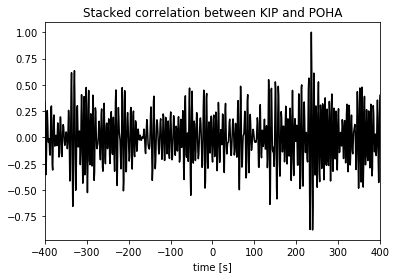

In [234]:
# Plotting

plotStack(st,stack,400,figurename='trigger40')

In [235]:
client = Client("IRIS")
t1= UTCDateTime("2018-05-04 22:32:55")
t2= t1+10*86400
ste=client.get_waveforms(network="IU", station="KIP",location="00", channel="LHZ",
                               starttime=t1, endtime=t2)

In [236]:
# Preprocessing

ste.detrend('linear')
ste.filter('bandpass', freqmin=0.1, freqmax=0.2, zerophase=True)
for tr in ste:
    tr = whiten(tr, 0.1, 0.2)

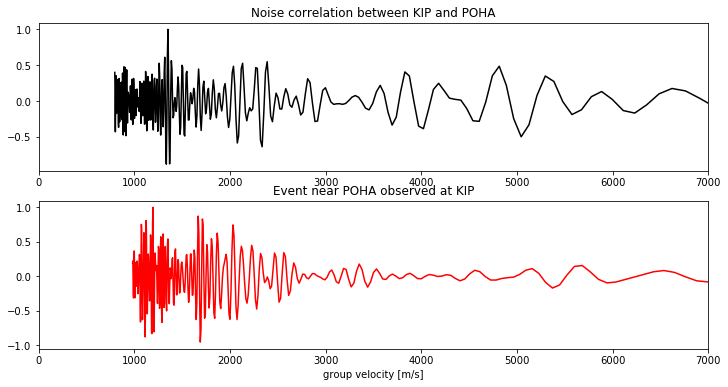

In [237]:
# Plotting

plotXcorrEvent(ste, stn, stack, 400,figurename="Trigger_earthquake_1")

In [238]:
# observation as we increase threshold value, noise decrease but the distrotion increases, optimal threshold found to be 35